# Projeto de IC

## Otimização de Hiperparâmetros da Rede Neural

### Revisão da Proposta

As equações de Navier-Stokes descrevem o comportamento de fluidos, incluindo o escoamento plenamente desenvolvido bidimensional em um canal com perfil de velocidade parabólico. Para esse caso específico, em coordenadas cartesianas $(x, y)$, as equações de Navier-Stokes simplificadas podem ser expressas como:

\begin{equation}
    \text{Equação da Conservação da Massa:} \quad \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\end{equation}
    
\begin{equation}
    \text{Equação do Movimento em } x : \quad \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
\end{equation}
    
\begin{equation}
    \text{Equação do Movimento em } y: \quad \frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)
\end{equation}

### Preparação do Ambiente

In [16]:
# Machine Learning puro
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Bibliotecas de apoio
import numpy as np

# Bibliotecas de visualização gráficas
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

#Manipuação de dados
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

import warnings

# Suprimir todos os alertas
warnings.filterwarnings("ignore")

# Alguns sets
np.random.seed(1)
pd.options.display.float_format = '{:.8f}'.format  

### Tratamento de Dados

Aqui, preparam-se os dados para sua importação dentro de um arquivo ```.json```, utilizando a biblioteca Pandas. Com isso, é possível metrificar bem adequadamente o impacto dos hiperparâmetros da rede.

In [17]:
# Read the JSON file into a DataFrame
df = pd.read_csv("dados_otimizacao.csv")

# Display the DataFrame
df.head()

,Unnamed: 0,run,perda,lr,alpha,numero_pontos,numero_neuronios,numero_camadas
0,0,lr_experiment_1,0.08626947,0.00005417,0.31609735,1905,13,8
1,1,lr_experiment_2,0.06998327,0.00022552,0.31609735,1905,13,8
2,2,lr_experiment_3,0.12534909,0.00038628,0.31609735,1905,13,8
3,3,lr_experiment_4,0.06369212,0.00024497,0.31609735,1905,13,8
4,4,lr_experiment_5,0.04941825,0.00079187,0.31609735,1905,13,8


### Bloco Residual

A rede neural utilizada para este projeto utilizad a abordagem residual, permitindo comprimir a dimensão total da rede, com menos neurônios e menos camadas.

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.linear2 = nn.Linear(out_features, out_features)

        # Adicionar camada linear para ajustar dimensões, se necessário
        if in_features != out_features:
            self.adjust_dimensions = nn.Linear(in_features, out_features)
        else:
            self.adjust_dimensions = None

    def forward(self, x):
        residual = x
        x = torch.tanh(self.linear1(x))  # Modificado para tangente hiperbólica
        x = self.linear2(x)

        # Ajustar dimensões da entrada residual, se necessário
        if self.adjust_dimensions is not None:
            residual = self.adjust_dimensions(residual)

        if residual.shape[1] == x.shape[1]:  # Verifica se as dimensões são compatíveis para a conexão de pulo
            x += residual  # Conexão de pulo
        else:
            raise RuntimeError("Dimensões incompatíveis para a conexão de pulo.")
        return torch.tanh(x)  # Modificado para tangente hiperbólica

### Classe de Controle

Abaixo está a ```pinn_ns_class```, a classe que gera os objetos correspondentes ao modelo de solução das equações acima.

In [19]:
class pinn_ns_class:

  def __init__(self, comprimento_x: float, comprimento_y: float, pressao: float,
               pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
               pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
               alpha: float = 0.2, epocas: int = 10000, learning_rate: float = 0.01,
               device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')):

      self.comprimento_x = comprimento_x
      self.comprimento_y = comprimento_y
      self.pressao = pressao
      self.alpha = alpha
      self.epocas = epocas
      self.learning_rate = learning_rate
      self.pontos_no_contorno = pontos_no_contorno
      self.pontos_no_dominio = pontos_no_dominio
      self.numero_de_neuronios = numero_de_neuronios
      self.learning_rate = learning_rate
      self.pontos_no_contorno_validacao = pontos_no_contorno_validacao
      self.pontos_no_dominio_validacao = pontos_no_dominio_validacao

      if type(device) == str:
        device = torch.device(device)
      self.device = device


  def gerar_lado(self, pontos_por_lado, comprimento_x, comprimento_y, pressao_total, velocidade = 0):
        x = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_x)
        y = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_y)
        p = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=pressao_total)
        if (velocidade == 0):
          u = 0 * np.ones((pontos_por_lado, 1))
          v = 0 * np.ones((pontos_por_lado, 1))
        else:
          u = np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
          v = np.sin(np.pi*x)*np.sin(np.pi*y)

        return x, y, p, u, v

  def gerar_pontos_contorno(self):
        pontos_por_lado = self.pontos_no_contorno // 6
        x1, y1, p1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.pressao)
        x2, y2, p2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.pressao)
        x3, y3, p3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)
        x4, y4, p4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)

        x_inicial, y_inicial, p_inicial, u_inicial, v_inicial = self.gerar_lado(
            2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados
        x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
        y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
        p_todos = np.vstack((p1, p2, p3, p4, p_inicial))
        u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
        v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

        # Criar arrays X e Y
        X_contorno = np.hstack((x_todos, y_todos, p_todos))
        Y_contorno = np.hstack((u_todos, v_todos))

        self.X_contorno = X_contorno
        self.Y_contorno = Y_contorno

  def gerar_pontos_validacao(self):
        pontos_por_lado_validacao = self.pontos_no_contorno_validacao // 6
        x1, y1, p1, u1, v1 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, 0, self.pressao)
        x2, y2, p2, u2, v2 = self.gerar_lado(pontos_por_lado_validacao, 0, self.comprimento_y, self.pressao)
        x3, y3, p3, u3, v3 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.pressao)
        x4, y4, p4, u4, v4 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.pressao)

        x_inicial_validacao, y_inicial_validacao, p_inicial_validacao, u_inicial_validacao, v_inicial_validacao = self.gerar_lado(
            2 * pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados em validação
        x_todos_validacao = np.vstack((x1, x2, x3, x4, x_inicial_validacao))
        y_todos_validacao = np.vstack((y1, y2, y3, y4, y_inicial_validacao))
        p_todos_validacao = np.vstack((p1, p2, p3, p4, p_inicial_validacao))
        u_todos_validacao = np.vstack((u1, u2, u3, u4, u_inicial_validacao))
        v_todos_validacao = np.vstack((v1, v2, v3, v4, v_inicial_validacao))

        # Arrays X e Y para validação
        X_contorno_validacao = np.hstack((x_todos_validacao, y_todos_validacao, p_todos_validacao))
        Y_contorno_validacao = np.hstack((u_todos_validacao, v_todos_validacao))

        self.X_contorno_validacao = X_contorno_validacao
        self.Y_contorno_validacao = Y_contorno_validacao

  def gerar_pontos_equacao(self):
    x_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_x)
    y_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_y)
    p_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.pressao)

    x_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_x)
    y_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_y)
    p_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.pressao)

    X_equacao = np.hstack((x_dominio, y_dominio, p_dominio))
    X_equacao_validacao = np.hstack((x_dominio_validacao, y_dominio_validacao, p_dominio_validacao))

    self.X_equacao = torch.tensor(X_equacao, requires_grad=True, dtype=torch.float).to(self.device)
    self.X_equacao_validacao = torch.tensor(X_equacao_validacao, requires_grad=True, dtype=torch.float).to(self.device)

  def criar_rede_neural(self):
      # Criar uma lista de todas as camadas
      camadas = []

      # Adicionar camadas residuais
      for i in range(len(self.numero_de_neuronios)-2):
        camadas.append(ResidualBlock(self.numero_de_neuronios[i], self.numero_de_neuronios[i + 1]))

      # Última camada sem ativação (pode ser ajustado conforme necessário)
      camadas.append(nn.Linear(self.numero_de_neuronios[-2], self.numero_de_neuronios[-1]))

      # Criar a rede
      self.rna = nn.Sequential(*camadas)

  def calcular_gradientes(self, u, v, p, x, y):
    # Calcular os gradientes
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True, allow_unused=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True, allow_unused=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True, allow_unused=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True, allow_unused=True)[0]
    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True, allow_unused=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True, allow_unused=True)[0]

    return u_x, u_y, u_xx, v_x, v_y, v_yy, p_x, p_y

  def calc_residuo(self):
    rho = 997  # densidade do fluido
    nu = 0.1   # viscosidade cinemática

    x = self.X_equacao[:, 0].reshape(-1, 1)
    y = self.X_equacao[:, 1].reshape(-1, 1)
    p = self.X_equacao[:, 2].reshape(-1, 1)

    x_validacao = self.X_equacao_validacao[:, 0].reshape(-1, 1)
    y_validacao = self.X_equacao_validacao[:, 1].reshape(-1, 1)
    p_validacao = self.X_equacao_validacao[:, 2].reshape(-1, 1)

    V = self.rna(torch.hstack((x, y, p)))
    u = V[:, 0].reshape(-1, 1)
    v = V[:, 1].reshape(-1, 1)

    V_validacao = self.rna(torch.hstack((x_validacao, y_validacao, p_validacao)))
    u_validacao = V_validacao[:, 0].reshape(-1, 1)
    v_validacao = V_validacao[:, 1].reshape(-1, 1)

    u_x, u_y, u_xx, v_x, v_y, v_yy, p_x, p_y = self.calcular_gradientes(u, v, p, x, y)

    u_x_validacao, u_y_validacao, u_xx_validacao, v_x_validacao, v_y_validacao, v_yy_validacao, p_x_validacao, p_y_validacao = self.calcular_gradientes(u_validacao, v_validacao, p_validacao, x_validacao, y_validacao)

    residual_mass = u_x + v_y  # Conservation of mass
    residual_u = u * u_x + v * u_y + (1/rho) - nu * (u_xx + v_yy)
    residual_v = u * v_x + v * v_y + (1/rho) - nu * (u_xx + v_yy)

    residual_mass_validacao = u_x_validacao + v_y_validacao
    residual_u_validacao =  u_validacao * u_x_validacao + v_validacao * u_y_validacao - (1/997) + 1e-6 * (u_xx_validacao + v_yy_validacao)
    residual_v_validacao = u_validacao * v_x_validacao + v_validacao * v_y_validacao - (1/997) + 1e-6 * (u_xx_validacao + v_yy_validacao)

    self.residual_mass = residual_mass
    self.residual_u = residual_u
    self.residual_v = residual_v

    self.residual_mass_validacao = residual_mass_validacao
    self.residual_u_validacao = residual_u_validacao
    self.residual_v_validacao = residual_v_validacao

    residuo_total = torch.cat((residual_mass, residual_u, residual_v), dim=1)
    self.residuo_total = residuo_total

    residuo_total_validacao = torch.cat((residual_mass_validacao, residual_u_validacao, residual_v_validacao), dim=1)
    self.residuo_total_validacao = residuo_total_validacao


    return residuo_total_validacao

  def calc_perda_equacao(self):
      self.calc_residuo()
      residuo = torch.mean(torch.square(self.residuo_total))
      residuo_validacao = torch.mean(torch.square(self.residuo_total_validacao))

      self.perda_equacao = residuo
      self.perda_equacao_validacao = residuo_validacao

  def calc_perda(self):
      self.calc_perda_contorno()
      self.calc_perda_equacao()

      perda = (1-self.alpha)*self.perda_contorno + self.alpha*self.perda_equacao
      perda_validacao = (1-self.alpha)*self.perda_contorno_validacao + self.alpha*self.perda_equacao_validacao

      self.perda = perda
      self.perda_validacao = perda_validacao
      self.perda_contorno = self.perda_contorno
      self.perda_contorno_validacao = self.perda_contorno_validacao
      self.perda_equacao = self.perda_equacao
      self.perda_equacao_validacao = self.perda_equacao_validacao

  def definicao_otimizador(self):
      self.gerar_pontos_validacao()
      otimizador = torch.optim.Adam(self.rna.parameters(),self.learning_rate)
      agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

      self.X_equacao = torch.tensor(self.X_equacao,requires_grad=True,dtype=torch.float)
      self.X_contorno = torch.tensor(self.X_contorno,dtype=torch.float)
      self.Y_contorno = torch.tensor(self.Y_contorno,dtype=torch.float)

      self.X_equacao = self.X_equacao.to(self.device)
      self.X_contorno = self.X_contorno.to(self.device)
      self.Y_contorno = self.Y_contorno.to(self.device)
      self.rna = self.rna.to(self.device)

      self.X_equacao_validacao = torch.tensor(self.X_equacao_validacao,requires_grad=True,dtype=torch.float)
      self.X_contorno_validacao = torch.tensor(self.X_contorno_validacao,dtype=torch.float)
      self.Y_contorno_validacao = torch.tensor(self.Y_contorno_validacao,dtype=torch.float)

      self.X_equacao_validacao = self.X_equacao_validacao.to(self.device)
      self.X_contorno_validacao = self.X_contorno_validacao.to(self.device)
      self.Y_contorno_validacao = self.Y_contorno_validacao.to(self.device)
      self.rna = self.rna.to(self.device)

  def calc_perda_contorno(self):
    Y_predito = self.rna(self.X_contorno)
    Y_predito_validacao = self.rna(self.X_contorno_validacao)

    perda_contorno = nn.functional.mse_loss(Y_predito, self.Y_contorno)
    perda_contorno_validacao = nn.functional.mse_loss(Y_predito_validacao, self.Y_contorno_validacao)

    self.perda_contorno = perda_contorno
    self.perda_contorno_validacao = perda_contorno_validacao

  def regerar_pontos_equacao(self):
    pontos_por_lado = self.pontos_no_dominio // 4

    x1, y1, p1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.pressao)
    x2, y2, p2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.pressao)
    x3, y3, p3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)
    x4, y4, p4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4))
    y_todos = np.vstack((y1, y2, y3, y4))
    p_todos = np.vstack((p1, p2, p3, p4))
    u_todos = np.vstack((u1, u2, u3, u4))
    v_todos = np.vstack((v1, v2, v3, v4))

    # Criar arrays X e Y
    X_equacao = np.hstack((x_todos, y_todos, p_todos))
    Y_equacao = np.hstack((u_todos, v_todos))

    # Converter para tensores
    X_equacao = torch.tensor(X_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_equacao = torch.tensor(Y_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_equacao = X_equacao
    self.Y_equacao = Y_equacao

  def regerar_pontos_contorno(self):
    pontos_por_lado = self.pontos_no_contorno // 6
    x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.pressao)
    x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.pressao)
    x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)
    x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.pressao)

    x_inicial, y_inicial, t_inicial, u_inicial, v_inicial = self.gerar_lado(
        2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
    )

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
    y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
    t_todos = np.vstack((t1, t2, t3, t4, t_inicial))
    u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
    v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

    # Criar arrays X e Y
    X_contorno = np.hstack((x_todos, y_todos, t_todos))
    Y_contorno = np.hstack((u_todos, v_todos))

    # Converter para tensores
    # X_contorno = torch.tensor(X_contorno, requires_grad=True, dtype=torch.float).to(self.device)
    # Y_contorno = torch.tensor(Y_contorno, requires_grad=True, dtype=torch.float).to(self.device)

    X_contorno = torch.tensor(X_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_contorno = torch.tensor(Y_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_contorno = X_contorno
    self.Y_contorno = Y_contorno

  def treinamento_da_rede(self):
    otimizador = torch.optim.Adam(self.rna.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

    perda_historico = np.zeros(self.epocas)
    perda_contorno_historico = np.zeros(self.epocas)
    perda_equacao_historico = np.zeros(self.epocas)

    perda_historico_validacao = np.zeros(self.epocas)
    perda_contorno_historico_validacao = np.zeros(self.epocas)
    perda_equacao_historico_validacao = np.zeros(self.epocas)

    epocas = np.array(range(self.epocas))

    # Colocar rede em modo de treinamento
    self.rna.train()

    # FAZER ITERAÇÃO
    for epoca in epocas:
        # Resortear pontos
        # self.gerar_pontos_equacao()

        # Inicializar gradientes
        otimizador.zero_grad()

        # Calcular perdas
        self.calc_perda()

        # Backpropagation
        self.perda.backward()

        # Passo do otimizador
        otimizador.step()
        agendador.step()

        # Guardar logs
        perda_historico[epoca] = self.perda.item()
        perda_contorno_historico[epoca] = self.perda_contorno.item()
        perda_equacao_historico[epoca] = self.perda_equacao.item()

        perda_historico_validacao[epoca] = self.perda_validacao.item()
        perda_contorno_historico_validacao[epoca] = self.perda_contorno_validacao.item()
        perda_equacao_historico_validacao[epoca] = self.perda_equacao_validacao.item()

        # caso queira acompanhar 
        # if epoca % 500 == 0:
        #     print(f'Epoca: {epoca}, Perda: {self.perda.item()} (Contorno: {self.perda_contorno.item()}, Equacao: {self.perda_equacao.item()})')
        #     print(f'Perda Validação: {self.perda_validacao.item()} (Contorno Validação: {self.perda_contorno_validacao.item()}, Equacao: {self.perda_equacao_validacao.item()})')

        # Ressortear os pontos - evitar overfitting
        # self.regerar_pontos_validacao()
        self.regerar_pontos_contorno()
        self.regerar_pontos_equacao()

    self.perda_historico = perda_historico
    self.perda_contorno_historico = perda_contorno_historico
    self.perda_equacao_historico = perda_equacao_historico

    self.perda_historico_validacao = perda_historico_validacao
    self.perda_contorno_historico_validacao = perda_contorno_historico_validacao
    self.perda_equacao_historico_validacao = perda_equacao_historico_validacao

  def calcular_grid(self, nx=101, ny=101,nt=101):
    # Definir grid
    x = np.linspace(0.,self.comprimento_x,nx)
    y = np.linspace(0.,self.comprimento_y,ny)
    t = np.linspace(0.,self.pressao,nt)
    [t_grid, y_grid, x_grid] = np.meshgrid(t,y,x)

    x = torch.tensor(x_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)
    y = torch.tensor(y_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)
    t = torch.tensor(t_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)

    # Avaliar modelor
    self.rna.eval()
    Y_pred = self.rna(torch.hstack((x,y,t)))
    # Formatar resultados em array
    u_pred = Y_pred.cpu().detach().numpy()[:,0].reshape(x_grid.shape)
    v_pred = Y_pred.cpu().detach().numpy()[:,1].reshape(x_grid.shape)

    self.x_grid = x_grid
    self.y_grid = y_grid
    self.t_grid = t_grid
    self.u_pred = u_pred
    self.v_pred = v_pred


  def plot_resultados(self, epocas=101):
    # Calcular valores da função e gerar grids
    self.calcular_grid()

    ind_t_plot = 50  # Esse é o índice do tempo a ser plotado

    # Extrair uma "fatia" dos arrays de coordenadas e soluções
    x_plot = self.x_grid[:, ind_t_plot, :]
    y_plot = self.y_grid[:, ind_t_plot, :]
    u_plot = self.u_pred[:, ind_t_plot, :]

    # Check dimensions and data types of x_plot, y_plot, and u_plot

    # Check if the data is not empty

    # Plot the surface
    fig = go.Figure(data=[go.Surface(x=x_plot, y=y_plot, z=u_plot)])

    # Check scene settings
    fig.update_layout(scene=dict(aspectratio=dict(x=1.5, y=1.5, z=0.5)))

    # Show the figure
    fig.show()

### Função de Medição de Qualidade

Com a função abaixo, pode-se controlar a criação de novos objetos, utilizando um conjunto específico de hiperparâmetros, os quais são a base de estudo da otimização.

In [20]:
def medicao_qualidade(comprimento_x: int = 1, comprimento_y: int = 1, pressao: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    # Criação do Objeto
    pinn_ns = pinn_ns_class(comprimento_x, comprimento_y, pressao, pontos_no_contorno, pontos_no_dominio, numero_de_neuronios, pontos_no_contorno_validacao, pontos_no_dominio_validacao, alpha, epocas, learning_rate, device)

    # Pontos de contorno e domínio para o treinamento e para a validação
    pinn_ns.gerar_pontos_contorno()
    pinn_ns.gerar_pontos_equacao()

    # Criação da rede
    pinn_ns.criar_rede_neural()

    # Passando para GPU e otimizando
    pinn_ns.definicao_otimizador()

    # Realizar as correções nas chamadas dos métodos da classe pinn
    pinn_ns.X_contorno = pinn_ns.X_contorno.clone().detach().to(device)
    pinn_ns.Y_contorno = pinn_ns.Y_contorno.clone().detach().to(device)
    pinn_ns.X_equacao_validacao = pinn_ns.X_equacao_validacao.clone().detach().requires_grad_(True).to(device)
    pinn_ns.X_contorno_validacao = pinn_ns.X_contorno_validacao.clone().detach().to(device)
    pinn_ns.Y_contorno_validacao = pinn_ns.Y_contorno_validacao.clone().detach().to(device)

    # Treinamento
    pinn_ns.treinamento_da_rede()


    return pinn_ns

A função ```generate_initial_values()``` realiza a seleção dos valores para teste.

In [21]:
# Function to generate initial random values for parameters
def generate_initial_values():
    lr = 10 ** np.random.uniform(-5, 0)
    alpha = np.random.uniform(0.1, 0.4)
    numero_pontos = np.random.randint(1000, 3501)
    numero_neuronios = np.random.randint(2, 16)
    numero_camadas = np.random.randint(3, 9)
    return [lr, alpha, numero_pontos, numero_neuronios, numero_camadas]

Aqui, o preparamento para o teste

In [22]:
# Initialize parameters
initial_values = generate_initial_values()

# Create DataFrame to store results
columns = ["run", "perda", "lr", "alpha", "numero_pontos", "numero_neuronios", "numero_camadas"]
df = pd.DataFrame(columns=columns)

Por fim, a função ```run_experiments()```, que permite rodar os experimentos com hiperparâmetros

In [23]:
# Function to run 10 random experiments for one parameter while keeping others fixed
def run_experiments(vary_param, fixed_values, trials=10):
    param_index = ["lr", "alpha", "numero_pontos", "numero_neuronios", "numero_camadas"].index(vary_param)
    best_result = None

    for i in range(trials):
        values = fixed_values.copy()

        if vary_param == "lr":
            values[param_index] = 10 ** np.random.uniform(-5, 0)
        elif vary_param == "alpha":
            values[param_index] = np.random.uniform(0.1, 0.4)
        elif vary_param == "numero_pontos":
            values[param_index] = np.random.randint(1000, 3501)
        elif vary_param == "numero_neuronios":
            values[param_index] = np.random.randint(2, 16)
        elif vary_param == "numero_camadas":
            values[param_index] = np.random.randint(3, 9)

        rede = [3] + [values[3]] * values[4] + [2]
        pinn_ns = medicao_qualidade(1, 1, 1, 1000, values[2], rede, 300, 400, values[1], 700, values[0])
        
        new_data = {
            "run": f"{vary_param}_experiment_{i+1}",
            "perda": pinn_ns.perda_historico[-1],
            "lr": values[0],
            "alpha": values[1],
            "numero_pontos": values[2],
            "numero_neuronios": values[3],
            "numero_camadas": values[4]
        }

        df.loc[len(df)] = new_data

        if best_result is None or new_data["perda"] < best_result["perda"]:
            best_result = new_data
    
    return best_result, pinn_ns

Os testes abaixo

In [24]:
# Iterate over each parameter to find the optimal values
parameters = ["lr", "alpha", "numero_pontos", "numero_neuronios", "numero_camadas"]

for param in parameters:
    best_result, pinn_ns = run_experiments(param, initial_values)
    initial_values[["lr", "alpha", "numero_pontos", "numero_neuronios", "numero_camadas"].index(param)] = best_result[param]

In [25]:
# Save results to csv
df.to_csv('dados_otimizacao.csv')

### Resultados Obtidos

Abaixo, uma breve visualização dos resultados obtidos com a abordagem desenvolvida acima

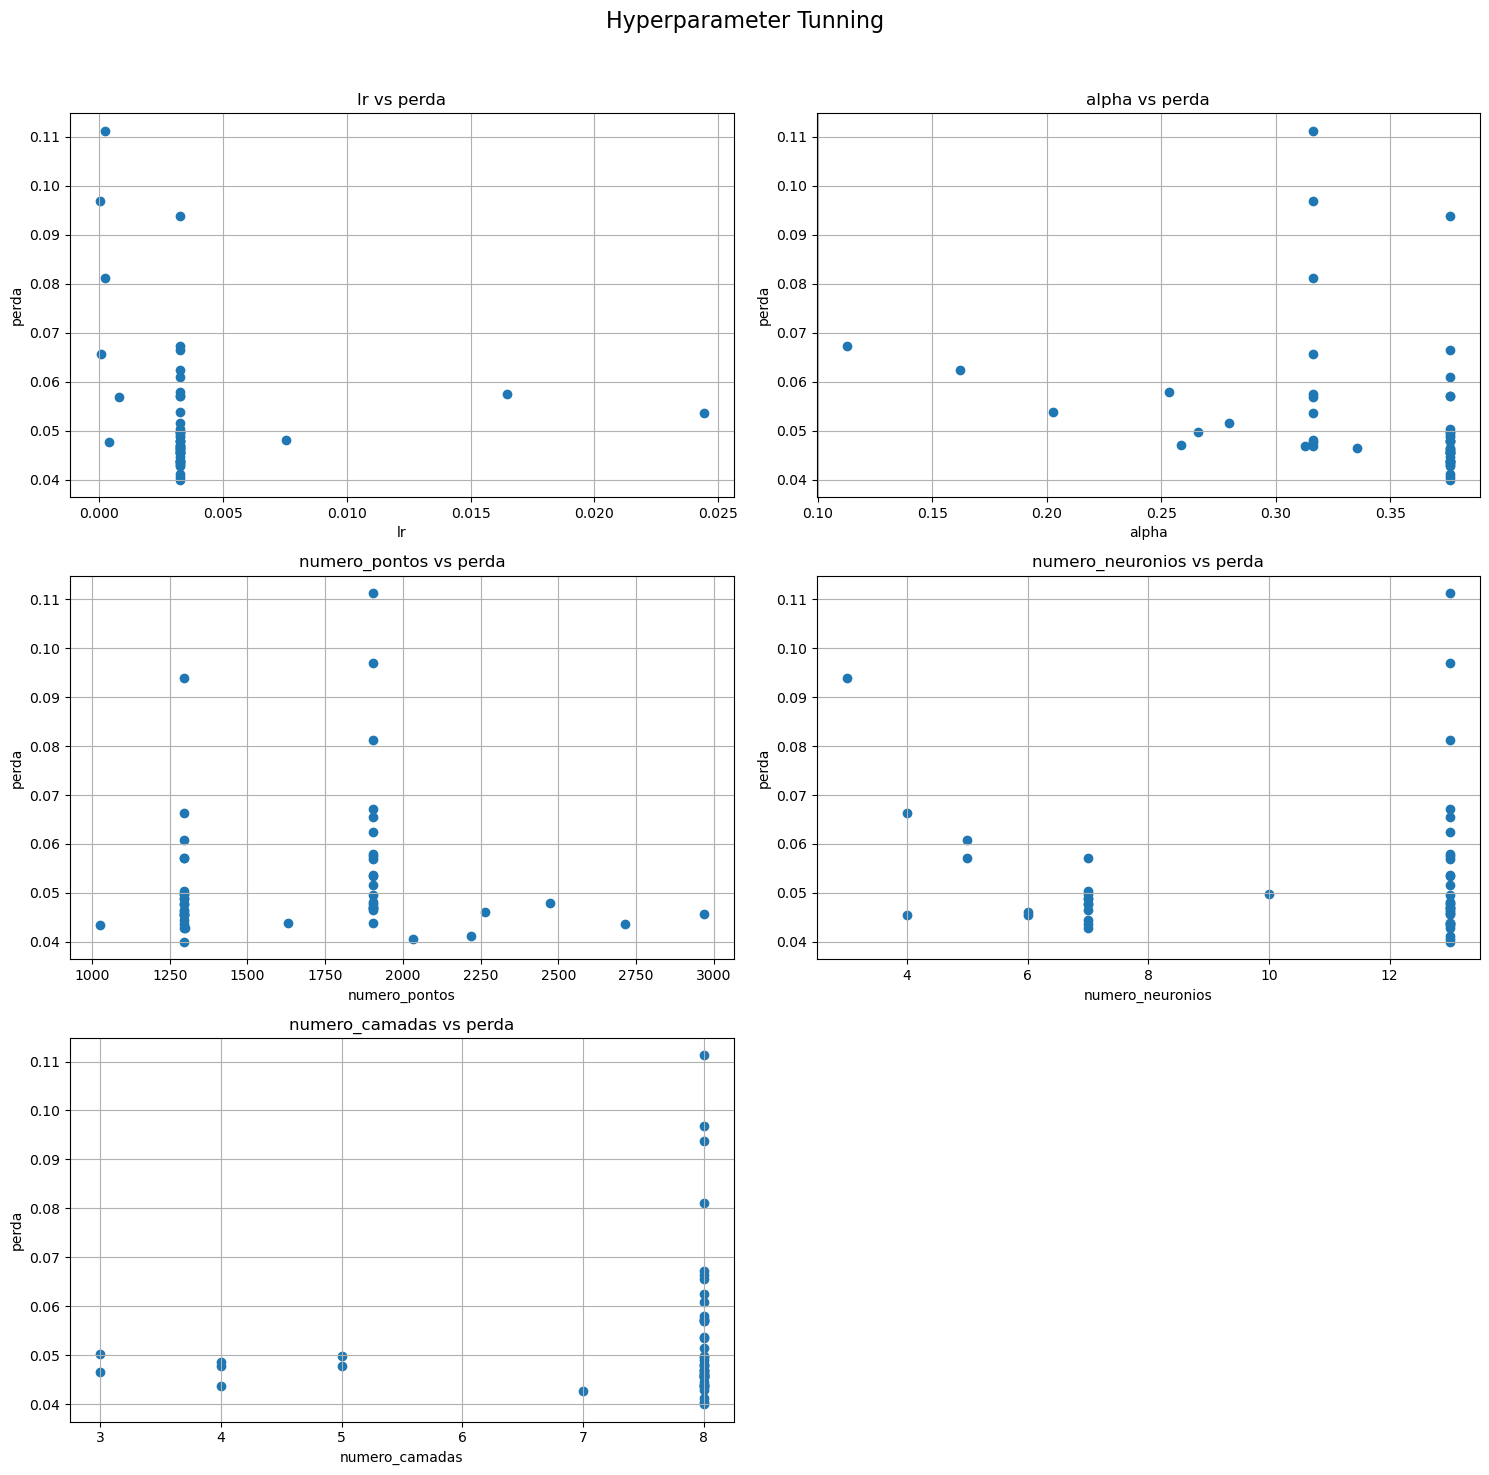

In [26]:
# Plotting the results
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Hyperparameter Tunning', fontsize=16)

param_names = ["lr", "alpha", "numero_pontos", "numero_neuronios", "numero_camadas"]
for i, param in enumerate(param_names):
    ax = axes.flat[i]
    ax.scatter(df[param], df["perda"])
    ax.set_title(f"{param} vs perda")
    ax.set_xlabel(param)
    ax.set_ylabel("perda")
    ax.grid(True)

# Remove the empty subplot (if any)
if len(param_names) < len(axes.flat):
    fig.delaxes(axes.flat[-1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('hyperparameter_sweeps.png')
plt.show()

In [27]:
pinn_ns.plot_resultados()

### Teste de Hipótese 

Verificar o maior grau de importância

In [28]:
# Loop through each parameter to compute correlation and p-value with 'perda'
for param in param_names:
    corr, p_value = pearsonr(df[param], df["perda"])
    print(f"Correlation between {param} and perda: {corr:.3f} (p-value: {p_value:.3e})")

Correlation between lr and perda: -0.147 (p-value: 3.085e-01)
Correlation between alpha and perda: -0.287 (p-value: 4.330e-02)
Correlation between numero_pontos and perda: 0.051 (p-value: 7.226e-01)
Correlation between numero_neuronios and perda: -0.031 (p-value: 8.321e-01)
Correlation between numero_camadas and perda: 0.162 (p-value: 2.602e-01)


### Regressão Simples

Basicamente, a ideia é verificar a regressão entre cada parâmetro e a perda, indicando se há ou não uma tendência linear.

In [29]:
# Loop through each parameter to perform linear regression with 'perda'
for param in param_names:
    X = df[param]
    y = df["perda"]
    X = sm.add_constant(X)  # Add a constant term for the intercept
    
    model = sm.OLS(y, X).fit()
    print(f"\nRegression results for {param} vs perda:")
    print(model.summary())


Regression results for lr vs perda:
                            OLS Regression Results                            
Dep. Variable:                  perda   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.059
Date:                Sun, 16 Jun 2024   Prob (F-statistic):              0.309
Time:                        21:50:54   Log-Likelihood:                 141.41
No. Observations:                  50   AIC:                            -278.8
Df Residuals:                      48   BIC:                            -275.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

### Regressão Múltiplca dos Dados

Com relação aos resultados dos parâmetros, verificando causalidade.

In [30]:
# Preparing the data for multiple linear regression
X = df[param_names]
y = df["perda"]
X = sm.add_constant(X)  # Add a constant term for the intercept

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  perda   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1.831
Date:                Sun, 16 Jun 2024   Prob (F-statistic):              0.126
Time:                        21:50:54   Log-Likelihood:                 145.59
No. Observations:                  50   AIC:                            -279.2
Df Residuals:                      44   BIC:                            -267.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0820      0.020  